<a href="https://colab.research.google.com/github/Jay-Down/ravelin_test/blob/main/ravelin_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Note:

This notebook was run on Google's Colab for ease of use of CatBoost (I have compiler issues with my OS).

Simply uploading to Colab along with the sample data ought to be enough to make it executable, hence why I haven't included any accompanying files handling requirements, environments, etc., though I suspect for reviewing this task it will be sufficient to just scan the PDF export or cell outputs below.

In [ ]:
!pip3 install catboost
!pip install ipywidgets
!pip install tqdm
!pip install shap
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from catboost import CatBoostClassifier, Pool, cv
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

import json
import re
from IPython.display import display

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # suppress sns future warning

# Ravelin Data Science Test
Below are some json profiles representing fictional customers from an ecommerce company. The profiles contain information about the customer, their orders, their transactions, what payment methods they used and whether the customer is fraudulent or not. Your task is to:

Transform the json profiles into a dataframe of feature vectors.
Provide exploratory analysis of the dataset, and to summarise and explain the key trends in the data, explaining which factors appear to be most important in predicting fraud.
Construct a model to predict if a customer is fraudulent based on their profile.
Report on the models success and show what features are most important in that model.
Please use Python for this exercise. You can use whatever external software libraries you think are appropriate.

We're looking for:

- Readable code
- High quality analysis
- Clear explanations of the analysis and conclusions

Please don't spend more than 3-4 hours on this task. You may find that there are more aspects of the data that you can realistically investigate in that time, and that's fine. If that is the case, please just describe what your next steps might be if there were more time allocated to the task.

In [ ]:
# read in json profiles line by line

with open('./sample_data/customers.json', 'r') as file:
    df = pd.concat([pd.json_normalize(json.loads(line)) for line in file])


In [ ]:
df.head()

,fraudulent,orders,paymentMethods,transactions,customer.customerEmail,customer.customerPhone,customer.customerDevice,customer.customerIPAddress,customer.customerBillingAddress
0,False,"[{'orderId': 'vjbdvd', 'orderAmount': 18, 'ord...","[{'paymentMethodId': 'wt07xm68b', 'paymentMeth...","[{'transactionId': 'a9lcj51r', 'orderId': 'vjb...",josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896"
0,True,"[{'orderId': 'nlghpa', 'orderAmount': 45, 'ord...","[{'paymentMethodId': 'y3xp697jx', 'paymentMeth...","[{'transactionId': '5mi94sfw', 'orderId': 'nlg...",evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...
0,False,"[{'orderId': 'yk34y2', 'orderAmount': 33, 'ord...","[{'paymentMethodId': '8pneoi03z', 'paymentMeth...","[{'transactionId': 'q3lyvbza', 'orderId': 'yk3...",andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250"
0,False,"[{'orderId': 'fbz9ep', 'orderAmount': 34, 'ord...","[{'paymentMethodId': 'pdxjdwui4', 'paymentMeth...","[{'transactionId': 'vx4cjc27', 'orderId': 'fbz...",rubenjuarez@yahoo.com,670.664.8168x94985,slovx60t0i558may4ks0,95de:8565:5a66:792c:26e0:6cfb:7d87:11af,"7769 Elizabeth Bridge Apt. 343\nNortonstad, FM..."
0,True,"[{'orderId': '56h7iw', 'orderAmount': 71, 'ord...","[{'paymentMethodId': 'w1i1zq3rg', 'paymentMeth...","[{'transactionId': 'q8j3dgni', 'orderId': '56h...",uchen@malone.com,1-981-877-0870,j0pd24k5h8dl2fqu0cz4,196.89.235.192,"148 Russell Lodge Apt. 445\nPort Jenniferside,..."


If a profile has made an order, it has arrays of dicts associated with order, transaction and payment info:

In [ ]:
df['orders'].iloc[0]

[{'orderId': 'vjbdvd',
  'orderAmount': 18,
  'orderState': 'pending',
  'orderShippingAddress': '5493 Jones Islands\nBrownside, CA 51896'},
 {'orderId': 'yp6x27',
  'orderAmount': 26,
  'orderState': 'fulfilled',
  'orderShippingAddress': '5493 Jones Islands\nBrownside, CA 51896'}]

I will aggregate this data for use in the customer-level df, engineering 'count' features for orders/transactions and paymentMethods.

I'll also flatten the arrays into their own dataframes to inspect the respective features within them and see if they show any relationship with the fraud labels:

In [ ]:
# generate customer ID for mapping orders/transactions/payment features back to customer df
df['cID'] = np.arange(df.shape[0])

In [ ]:
df['orderCount'] = df['orders'].apply(len)
df['transactionCount'] = df['transactions'].apply(len)
df['paymentMethodsCount'] = df['paymentMethods'].apply(len)

In [ ]:
supplementary_dfs = {}

for col in ['orders', 'transactions', 'paymentMethods']:
    tmp = df[col].copy()
    tmp.index = df[['cID','fraudulent']] # set index to retain fraud label
    tmp = tmp.explode()
    ix = pd.DataFrame(tmp.index.to_list(), columns=['cID', 'fraudulent'])
    tmp = pd.json_normalize(tmp) # loses idx; need to reinsert
    supplementary_dfs[col] = pd.concat([ix, tmp], axis=1)

In [ ]:
orders_df = supplementary_dfs['orders']
display(
    orders_df.head(),
    orders_df.shape,
    orders_df.describe()
)

,cID,fraudulent,orderId,orderAmount,orderState,orderShippingAddress
0,0,False,vjbdvd,18.0,pending,"5493 Jones Islands\nBrownside, CA 51896"
1,0,False,yp6x27,26.0,fulfilled,"5493 Jones Islands\nBrownside, CA 51896"
2,1,True,nlghpa,45.0,fulfilled,"898 Henry Ports\nNew Keithview, CA 95893-2497"
3,1,True,uw0eeb,23.0,fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...
4,1,True,bn44oh,43.0,fulfilled,"5093 Bryan Forks\nJoshuaton, FM 01565-9801"


(505, 6)

,cID,orderAmount
count,505.000000,478.000000
mean,85.469307,35.606695
std,48.999793,21.667298
min,0.000000,10.000000
25%,46.000000,22.000000
50%,87.000000,35.000000
75%,127.000000,46.000000
max,167.000000,353.000000


In [ ]:
trans_df = supplementary_dfs['transactions']
display(
    trans_df.head(),
    trans_df.shape,
    trans_df.describe()
)

,cID,fraudulent,transactionId,orderId,paymentMethodId,transactionAmount,transactionFailed
0,0,False,a9lcj51r,vjbdvd,wt07xm68b,18.0,False
1,0,False,y4wcv03i,yp6x27,wt07xm68b,26.0,False
2,1,True,5mi94sfw,nlghpa,41ug157xz,45.0,False
3,1,True,br8ba1nu,uw0eeb,41ug157xz,23.0,False
4,1,True,a33145ss,bn44oh,y3xp697jx,43.0,True


(650, 7)

,cID,transactionAmount
count,650.000000,623.000000
mean,85.303077,34.598716
std,49.408384,20.360247
min,0.000000,10.000000
25%,45.250000,21.000000
50%,85.000000,34.000000
75%,130.000000,45.000000
max,167.000000,353.000000


`transactionAmount` is largely redundant with `orderAmount` of orders df; only other potentially informative column is `transactionFailed`:

In [ ]:
# failed transaction counts for fraudulent customers:

trans_df.loc[trans_df['fraudulent']==1,'transactionFailed'].value_counts(normalize=True)

False    0.766537
True     0.233463
Name: transactionFailed, dtype: float64

In [ ]:
# failed transaction counts and for non-fraudulent:

trans_df.loc[trans_df['fraudulent']==0,'transactionFailed'].value_counts(normalize=True)

False    0.704918
True     0.295082
Name: transactionFailed, dtype: float64

Fraudulent transactions might fail at slightly higher rates.

In [ ]:
payments_df = supplementary_dfs['paymentMethods']
display(
    payments_df.head(),
    payments_df.shape,
    payments_df.describe(include=np.object_)
)

,cID,fraudulent,paymentMethodId,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer
0,0,False,wt07xm68b,True,card,JCB 16 digit,Citizens First Banks
1,1,True,y3xp697jx,True,bitcoin,VISA 16 digit,Solace Banks
2,1,True,6krszxc05,False,card,VISA 16 digit,Vertex Bancorp
3,1,True,5z1szj2he,False,card,Diners Club / Carte Blanche,His Majesty Bank Corp.
4,1,True,m52tx8e1s,False,card,Mastercard,Vertex Bancorp


(354, 7)

,paymentMethodId,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer
count,342,342,342,342,342
unique,342,2,4,10,20
top,wt07xm68b,False,card,JCB 16 digit,Her Majesty Trust
freq,1,302,242,65,43


#### Commentary on Supplementary DFs

Order, transaction and payments data are of different lengths for a single customer, implying there is not a one-to-one relationship between them. We'd expect this for payment methods, where a single payment method is likely to be used for multiple transactions, but it seems there are multiple transactions possible for a single order as well. Indeed, transactions seem to be the lowest granularity data available, with a many-to-one mapping from transactions to orders, payments and customers.

As such, we will build our model at this granularity to detect fraudulent transactions, based on the assumption that all of a fraudulent customer's transactions are classed as fraudulent in turn; i.e. that the 'fraud' label from the customer profile data can be reliably propagated to all the associated transaction data for a customer. This may not be true in real life - it may be that a customer's able to carry out legitimate transactions before becoming fraudulent, e.g. in the case of an account takeover - in which case we would need to build the model at a different granularity of data and would have to instead aggregate the associated order/transaction/payments data, but it will hold for the purposes of this exercise.

It is also probably a sensible design choice: it makes sense to make a fraud prediction at each transaction rather than, for example, waiting for an order to be completed, as this is our earliest chance to detect, and speed is essential in preventing fraud or maximising recoveries.

But before merging these DataFrames together, let's take a look at some of them a bit more closely.

From inspecting these features, several areas of investigation come to mind:
- what's the relationship between orders and fraud? Are higher order volumes/values more often fraudulent? Is there a geographic relationship between fraud and shipping address?
- relationship between fraud and transaction amount
- relationship between fraud and payment type/provider

Other info in customer df not that informative; lots of pii and unique identifiers like email, phone, deviceID, IP, etc.
Can engineer email domain, billing address state and check if same as shipping.



#### Orders

In [ ]:
# found NaN values propagated to dfs; need to drop
orders_df.loc[orders_df.isna().any(axis=1), :]

,cID,fraudulent,orderId,orderAmount,orderState,orderShippingAddress
27,9,True,NaN,NaN,NaN,NaN
74,23,True,NaN,NaN,NaN,NaN
106,34,False,NaN,NaN,NaN,NaN
110,38,False,NaN,NaN,NaN,NaN
115,40,True,NaN,NaN,NaN,NaN
116,41,False,NaN,NaN,NaN,NaN
120,43,False,NaN,NaN,NaN,NaN
121,44,False,NaN,NaN,NaN,NaN
127,47,False,NaN,NaN,NaN,NaN
142,51,False,NaN,NaN,NaN,NaN


In [ ]:
orders_df.dropna(inplace=True)
trans_df.dropna(inplace=True)
payments_df.dropna(inplace=True)

In [ ]:
orders_df.head()

,cID,fraudulent,orderId,orderAmount,orderState,orderShippingAddress
0,0,False,vjbdvd,18.0,pending,"5493 Jones Islands\nBrownside, CA 51896"
1,0,False,yp6x27,26.0,fulfilled,"5493 Jones Islands\nBrownside, CA 51896"
2,1,True,nlghpa,45.0,fulfilled,"898 Henry Ports\nNew Keithview, CA 95893-2497"
3,1,True,uw0eeb,23.0,fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...
4,1,True,bn44oh,43.0,fulfilled,"5093 Bryan Forks\nJoshuaton, FM 01565-9801"


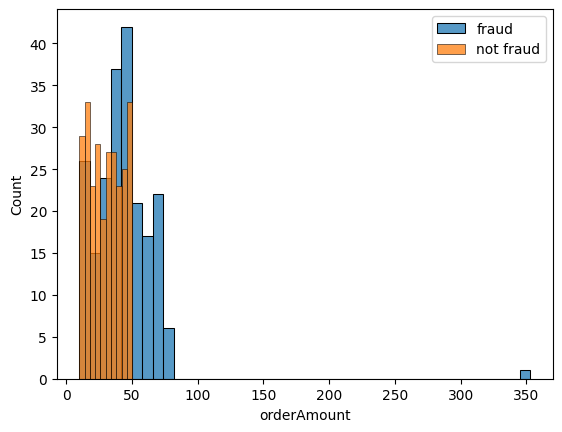

In [ ]:
fig, axs = plt.subplots()
sns.histplot(orders_df.loc[(orders_df['fraudulent']==1), 'orderAmount'], label='fraud', ax=axs)
sns.histplot(orders_df.loc[(orders_df['fraudulent']==0), 'orderAmount'], label='not fraud', ax=axs)
# axs.hist(orders_df.loc[(orders_df['fraudulent']==1), 'orderAmount'], label='fraud', bins=20)
#axs.hist(orders_df.loc[(orders_df['fraudulent']==0), 'orderAmount'], label='not fraud', bins=20)
axs.set_xlabel('orderAmount')
plt.legend()
plt.show()

fraudsters have higher order values; good difference in distributions, likely predictive

#### Payments

In [ ]:
payments_df.head()

,cID,fraudulent,paymentMethodId,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer
0,0,False,wt07xm68b,True,card,JCB 16 digit,Citizens First Banks
1,1,True,y3xp697jx,True,bitcoin,VISA 16 digit,Solace Banks
2,1,True,6krszxc05,False,card,VISA 16 digit,Vertex Bancorp
3,1,True,5z1szj2he,False,card,Diners Club / Carte Blanche,His Majesty Bank Corp.
4,1,True,m52tx8e1s,False,card,Mastercard,Vertex Bancorp


In [ ]:
payment_method_type = payments_df.groupby('fraudulent')['paymentMethodType'].value_counts(normalize=True)
payment_method_type.name = 'proportion'
payment_method_type = payment_method_type.reset_index()

In [ ]:
# bizarrely, causes an attribute error if left as bool
# payment_method_type['fraudulent'] = payment_method_type['fraudulent'].astype(str)

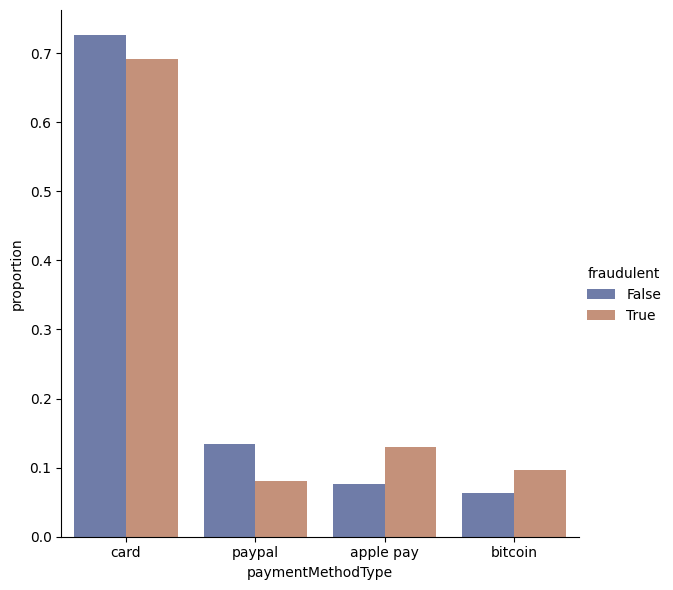

In [ ]:
g = sns.catplot(
    data=payment_method_type,
    kind="bar",
    x='paymentMethodType',
    y="proportion",
    hue="fraudulent",
    palette="dark",
    alpha=.6,
    height=6,
)



In [ ]:
payment_method_type = payments_df.groupby('fraudulent')['paymentMethodType'].value_counts(normalize=True)
payment_method_type.name = 'proportion'
payment_method_type = payment_method_type.reset_index()

In [ ]:
payment_method_provider = payments_df.groupby('fraudulent')['paymentMethodProvider'].value_counts(normalize=True)
payment_method_provider.name = 'proportion'
payment_method_provider = payment_method_provider.reset_index()
# payment_method_provider['fraudulent'] = payment_method_provider['fraudulent'].astype(str)

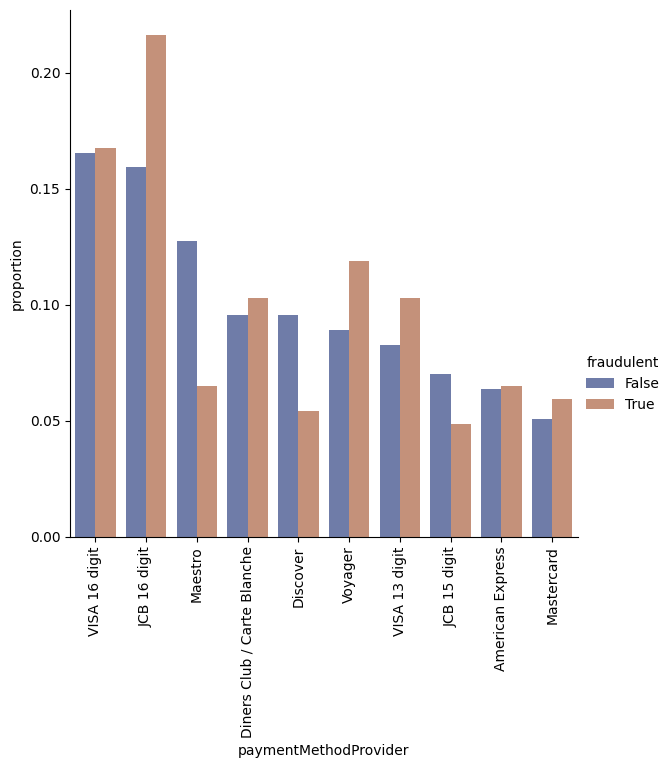

In [ ]:
g = sns.catplot(
    data=payment_method_provider,
    kind="bar",
    x='paymentMethodProvider',
    y="proportion",
    hue="fraudulent",
    palette="dark",
    alpha=.6,
    height=6,
)

g.set_xticklabels(rotation=90)

plt.show()

In [ ]:
payment_method_issuer = payments_df.groupby('fraudulent')['paymentMethodIssuer'].value_counts(normalize=True)
payment_method_issuer.name = 'proportion'
payment_method_issuer = payment_method_issuer.reset_index()
# payment_method_issuer['fraudulent'] = payment_method_issuer['fraudulent'].astype(str)

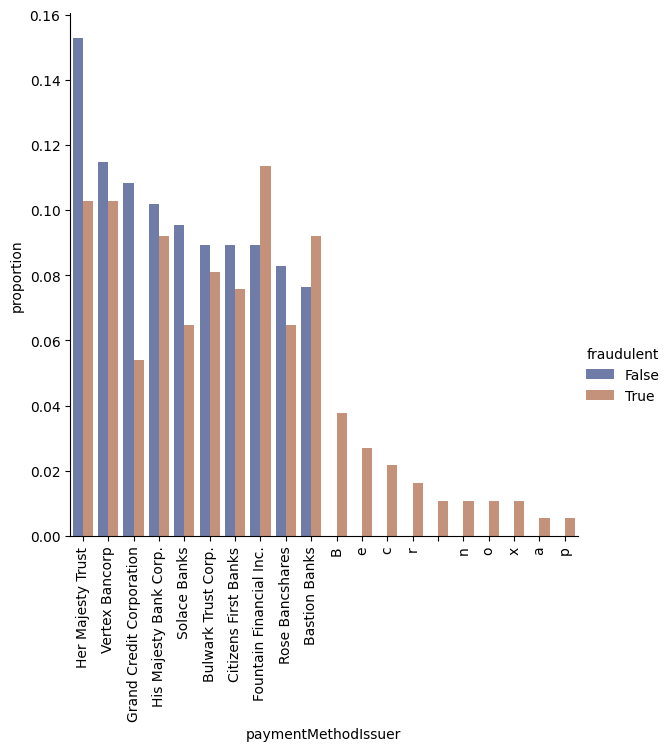

In [ ]:
g = sns.catplot(
    data=payment_method_issuer,
    kind="bar",
    x='paymentMethodIssuer',
    y="proportion",
    hue="fraudulent",
    palette="dark",
    alpha=.6,
    height=6,
)

g.set_xticklabels(rotation=90)

plt.show()

strange 'B', 'e', 'c', etc. values for payment method issuer for fraudulent instances only...


In [ ]:
payments_df.loc[payments_df['paymentMethodIssuer']=='B', :]

,cID,fraudulent,paymentMethodId,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer
17,5,True,wferzj9en,False,paypal,JCB 15 digit,B
116,64,True,5i61lz4t2,False,bitcoin,Discover,B
214,99,True,enx51erqn,True,paypal,Mastercard,B
226,105,True,5cd6aymfz,False,bitcoin,JCB 15 digit,B
270,126,True,h6cv0t3ga,False,bitcoin,VISA 16 digit,B
321,153,True,2d00yljsp,False,paypal,VISA 13 digit,B
339,164,True,wsy5c41nf,False,card,Voyager,B


In [ ]:
df.iloc[5, :]['paymentMethods']

[{'paymentMethodId': 'wferzj9en',
  'paymentMethodRegistrationFailure': False,
  'paymentMethodType': 'paypal',
  'paymentMethodProvider': 'JCB 15 digit',
  'paymentMethodIssuer': 'B'},
 {'paymentMethodId': 'n5fj5bc0e',
  'paymentMethodRegistrationFailure': False,
  'paymentMethodType': 'card',
  'paymentMethodProvider': 'VISA 16 digit',
  'paymentMethodIssuer': 'p'}]

spot check shows this is the provided data as opposed to an artefact of one of my processes... would probably be something to investigate in the upstream data generation process. Imagine it will be highly discriminative for these exemplars.

Some promising payment method info: good varying distributions between fraud and legit, likely some good predictors

#### Customers

In [ ]:
df.head(1)

,fraudulent,orders,paymentMethods,transactions,customer.customerEmail,customer.customerPhone,customer.customerDevice,customer.customerIPAddress,customer.customerBillingAddress,cID,orderCount,transactionCount,paymentMethodsCount
0,False,"[{'orderId': 'vjbdvd', 'orderAmount': 18, 'ord...","[{'paymentMethodId': 'wt07xm68b', 'paymentMeth...","[{'transactionId': 'a9lcj51r', 'orderId': 'vjb...",josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",0,2,2,1


In [ ]:
customer_cols = [
    'fraudulent',
    'cID',
    'customer.customerEmail',
    'customer.customerBillingAddress',
    'orderCount',
    'transactionCount',
    'paymentMethodsCount'
]

In [ ]:
customer_df = df.loc[:, customer_cols]

In [ ]:
customer_df.head(1)

,fraudulent,cID,customer.customerEmail,customer.customerBillingAddress,orderCount,transactionCount,paymentMethodsCount
0,False,0,josephhoward@yahoo.com,"5493 Jones Islands\nBrownside, CA 51896",2,2,1


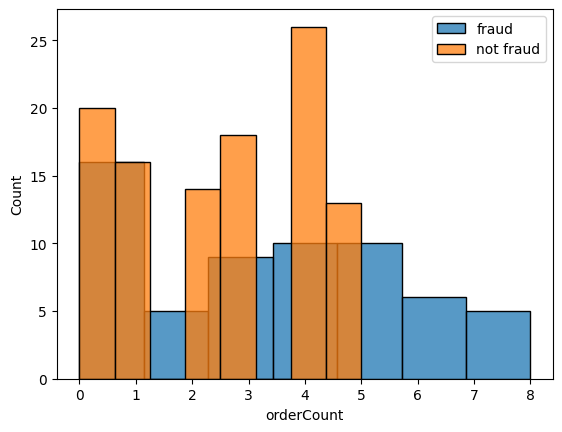

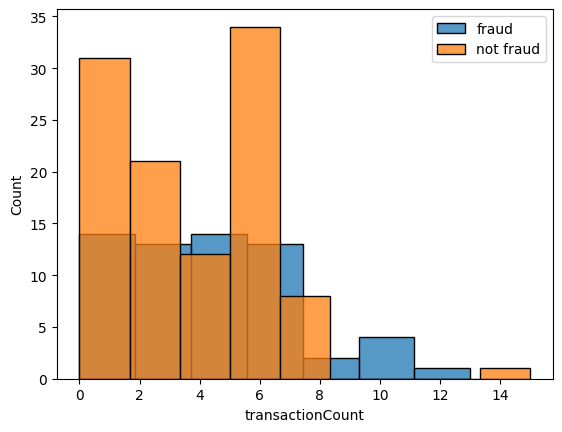

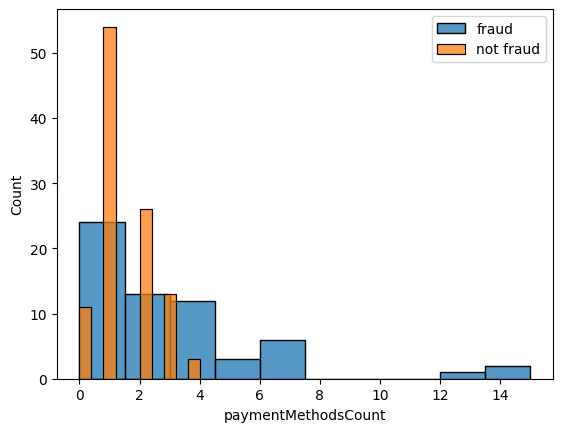

In [ ]:
for col in ['orderCount', 'transactionCount', 'paymentMethodsCount']:

    fig, axs = plt.subplots()
    sns.histplot(customer_df.loc[(customer_df['fraudulent']==1), col], label='fraud', ax=axs)
    sns.histplot(customer_df.loc[(customer_df['fraudulent']==0), col], label='not fraud', ax=axs)
    axs.set_xlabel(col)
    plt.legend()
    plt.show()

Again, good difference in distributions between the classes for these aggregate features, with fraudsters typically having higher values for orders, transactions and payment methods.

#### Creation of Transaction-level Dataset

Before merging these dataframes, it's worth considering how introducing this redundancy will change the distributions that we've just seen within our data.

A key consideration is the distribution of classes:

In [ ]:
df['fraudulent'].value_counts(normalize=True)

False    0.636905
True     0.363095
Name: fraudulent, dtype: float64

In [ ]:
trans_df['fraudulent'].value_counts(normalize=True)

False    0.58748
True     0.41252
Name: fraudulent, dtype: float64

There is no large shift in class balance from the profile-level classifications, and in fact it seems that as fraudsters typically make more orders/transactions than legitimate customers, the classes are actually slightly more balanced at transaction level than at customer level.

In [ ]:
dataset = trans_df.merge(
    orders_df.loc[:, ['orderId', 'orderAmount', 'orderState', 'orderShippingAddress']],
    on='orderId',
    how='left'
).merge(
    payments_df.iloc[:, 2:],
    on='paymentMethodId',
    how='left'
).merge(
    customer_df.iloc[:, 1:],
    on='cID',
    how='left'
)

In [ ]:
dataset.head()

,cID,fraudulent,transactionId,orderId,paymentMethodId,transactionAmount,transactionFailed,orderAmount,orderState,orderShippingAddress,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer,customer.customerEmail,customer.customerBillingAddress,orderCount,transactionCount,paymentMethodsCount
0,0,False,a9lcj51r,vjbdvd,wt07xm68b,18.0,False,18.0,pending,"5493 Jones Islands\nBrownside, CA 51896",True,card,JCB 16 digit,Citizens First Banks,josephhoward@yahoo.com,"5493 Jones Islands\nBrownside, CA 51896",2,2,1
1,0,False,y4wcv03i,yp6x27,wt07xm68b,26.0,False,26.0,fulfilled,"5493 Jones Islands\nBrownside, CA 51896",True,card,JCB 16 digit,Citizens First Banks,josephhoward@yahoo.com,"5493 Jones Islands\nBrownside, CA 51896",2,2,1
2,1,True,5mi94sfw,nlghpa,41ug157xz,45.0,False,45.0,fulfilled,"898 Henry Ports\nNew Keithview, CA 95893-2497",False,bitcoin,American Express,Bastion Banks,evansjeffery@yahoo.com,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7
3,1,True,br8ba1nu,uw0eeb,41ug157xz,23.0,False,23.0,fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,False,bitcoin,American Express,Bastion Banks,evansjeffery@yahoo.com,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7
4,1,True,a33145ss,bn44oh,y3xp697jx,43.0,True,43.0,fulfilled,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",True,bitcoin,VISA 16 digit,Solace Banks,evansjeffery@yahoo.com,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7


Some spot checks on the altered distributions of some features identified as likely important:

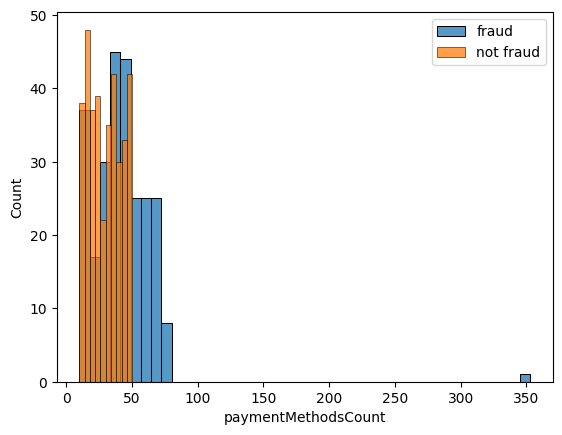

In [ ]:
fig, axs = plt.subplots()
sns.histplot(dataset.loc[(dataset['fraudulent']==1), 'orderAmount'], label='fraud', ax=axs)
sns.histplot(dataset.loc[(dataset['fraudulent']==0), 'orderAmount'], label='not fraud', ax=axs)
# axs.hist(orders_df.loc[(orders_df['fraudulent']==1), 'orderAmount'], label='fraud', bins=20)
#axs.hist(orders_df.loc[(orders_df['fraudulent']==0), 'orderAmount'], label='not fraud', bins=20)
axs.set_xlabel(col)
plt.legend()
plt.show()

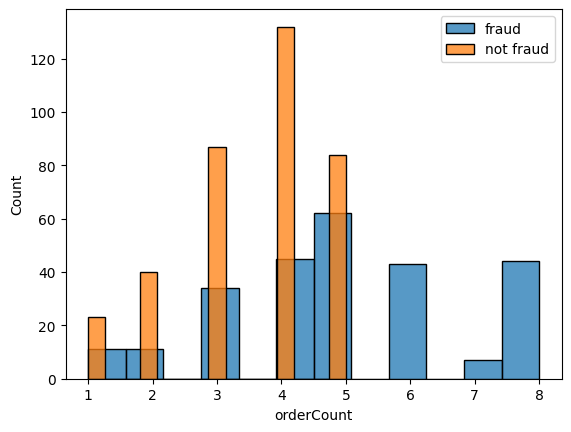

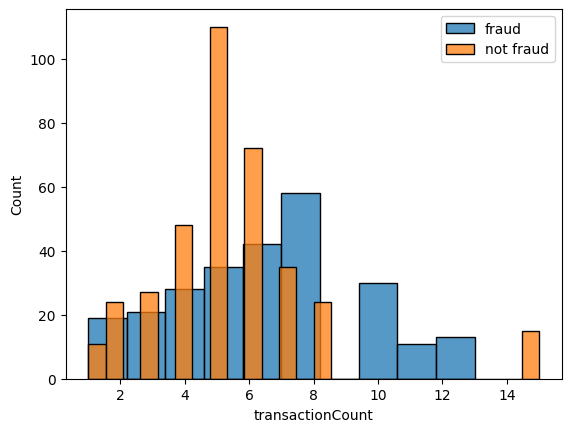

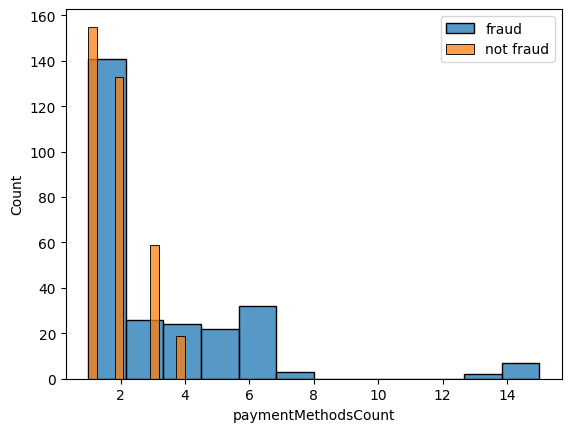

In [ ]:
for col in ['orderCount', 'transactionCount', 'paymentMethodsCount']:

    fig, axs = plt.subplots()
    sns.histplot(dataset.loc[(dataset['fraudulent']==1), col], label='fraud', ax=axs)
    sns.histplot(dataset.loc[(dataset['fraudulent']==0), col], label='not fraud', ax=axs)
    # axs.hist(orders_df.loc[(orders_df['fraudulent']==1), 'orderAmount'], label='fraud', bins=20)
    #axs.hist(orders_df.loc[(orders_df['fraudulent']==0), 'orderAmount'], label='not fraud', bins=20)
    axs.set_xlabel(col)
    plt.legend()
    plt.show()

In [ ]:
payment_method_provider = dataset.groupby('fraudulent')['paymentMethodProvider'].value_counts(normalize=True)
payment_method_provider.name = 'proportion'
payment_method_provider = payment_method_provider.reset_index()


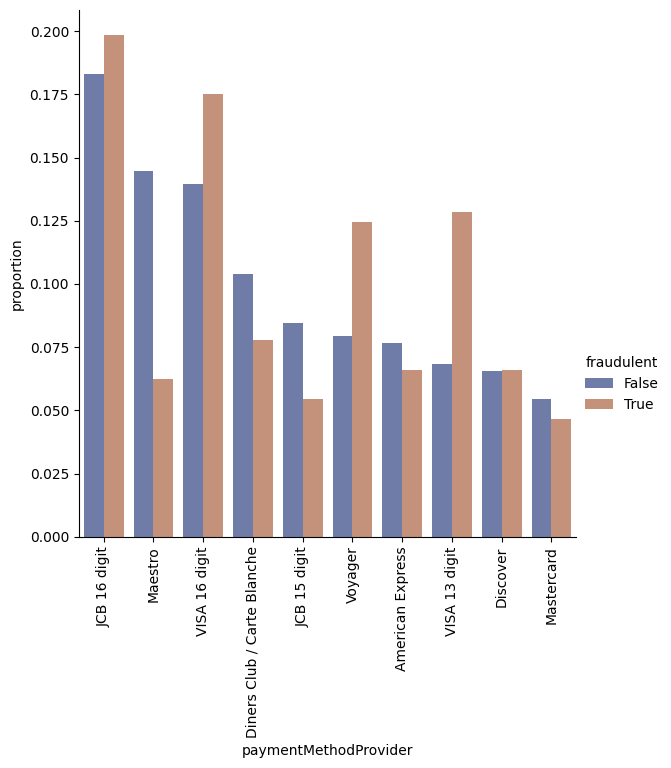

In [ ]:
g = sns.catplot(
    data=payment_method_provider,
    kind="bar",
    x='paymentMethodProvider',
    y="proportion",
    hue="fraudulent",
    palette="dark",
    alpha=.6,
    height=6,
)

g.set_xticklabels(rotation=90)

plt.show()

From these spot checks, it's clear that the distribution of these features is different when looking at a transaction granularity, but that both classes still have differing distributions and that they ought to still provide information to discriminate between them, so conclusions from earlier EDA about which to include should still be relevant.

#### Feature Engineering

In [ ]:
dataset.head()

,cID,fraudulent,transactionId,orderId,paymentMethodId,transactionAmount,transactionFailed,orderAmount,orderState,orderShippingAddress,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer,customer.customerEmail,customer.customerBillingAddress,orderCount,transactionCount,paymentMethodsCount
0,0,False,a9lcj51r,vjbdvd,wt07xm68b,18.0,False,18.0,pending,"5493 Jones Islands\nBrownside, CA 51896",True,card,JCB 16 digit,Citizens First Banks,josephhoward@yahoo.com,"5493 Jones Islands\nBrownside, CA 51896",2,2,1
1,0,False,y4wcv03i,yp6x27,wt07xm68b,26.0,False,26.0,fulfilled,"5493 Jones Islands\nBrownside, CA 51896",True,card,JCB 16 digit,Citizens First Banks,josephhoward@yahoo.com,"5493 Jones Islands\nBrownside, CA 51896",2,2,1
2,1,True,5mi94sfw,nlghpa,41ug157xz,45.0,False,45.0,fulfilled,"898 Henry Ports\nNew Keithview, CA 95893-2497",False,bitcoin,American Express,Bastion Banks,evansjeffery@yahoo.com,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7
3,1,True,br8ba1nu,uw0eeb,41ug157xz,23.0,False,23.0,fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,False,bitcoin,American Express,Bastion Banks,evansjeffery@yahoo.com,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7
4,1,True,a33145ss,bn44oh,y3xp697jx,43.0,True,43.0,fulfilled,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",True,bitcoin,VISA 16 digit,Solace Banks,evansjeffery@yahoo.com,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7


In [ ]:
# drop IDs
dataset.drop(['cID', 'transactionId', 'orderId', 'paymentMethodId'], axis=1, inplace=True)

In [ ]:
# also drop redundant orderAmount column
dataset[['orderAmount', 'transactionAmount']].corr()

,orderAmount,transactionAmount
orderAmount,1.0,1.0
transactionAmount,1.0,1.0


In [ ]:
dataset.drop('orderAmount', axis=1, inplace=True)

In [ ]:
# extract state information from billing and shipping address

def extract_state(address):

    pattern = r'([A-Z]{2})\s(\d{5})'
    match = re.search(pattern, address)
    if match:
        return match.group(1)
    else:
        return None


In [ ]:
dataset['customer.customerBillingAddress'] = dataset['customer.customerBillingAddress'].apply(extract_state)

In [ ]:
dataset['orderShippingAddress'] = dataset['orderShippingAddress'].apply(extract_state)

In [ ]:
# extract domain from email

def extract_domain(email):

    # Split the email address by '@' symbol
    parts = email.split('@')
    if len(parts) == 1:
        return None
    else:
        return parts[1]

In [ ]:
dataset['customer.customerEmail'] = dataset['customer.customerEmail'].apply((extract_domain))

In [ ]:
# see if billing/shipping address mismatch is different between classes

dataset['addressMismatch'] = (dataset['customer.customerBillingAddress']==dataset['orderShippingAddress'])

In [ ]:
mismatch_counts = dataset.groupby('fraudulent')['addressMismatch'].value_counts(normalize=True)

In [ ]:
# there is a distinction, though actually opposite to intuition;
# legitimate orders more likely to have different shipping/billing address

pd.DataFrame(mismatch_counts)

addressMismatch
fraudulent addressMismatch                 
False      True                    0.729508
           False                   0.270492
True       True                    0.610895
           False                   0.389105

### Category Cardinality

In [ ]:
dataset.describe(include=np.object_)

,transactionFailed,orderState,orderShippingAddress,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer,customer.customerEmail,customer.customerBillingAddress
count,623,623,623,623,623,623,623,623,623
unique,2,3,15,2,4,10,19,68,17
top,False,fulfilled,Other,False,card,JCB 16 digit,Her Majesty Trust,gmail.com,Other
freq,455,516,377,541,479,118,66,121,314


In [ ]:
def truncator(category_col, percentile=None, category_limit=None):
  """reduce cardinality of categorical columns based on top values"""

  assert percentile is None or category_limit is None, 'Specify only one of `percentile` or `category_limit`'

  ecdf = category_col.value_counts(normalize=True).cumsum()
  if percentile:
      ix = (ecdf-percentile).abs().idxmin()
      values = ecdf.loc[:ix].index
  else:
      values = ecdf.iloc[:category_limit].index

  def otherer(cat, values):
      if cat in values:
          return cat
      else:
          return 'Other'

  return category_col.apply(otherer, **{'values': values})


In [ ]:
# email and address columns have high cardinality... given small size of dataset, will truncate these to just top 10 or 15 categories

for p in np.arange(0.1, 0.9, 0.1):
    print(f"p: {p}, n. uniques: {truncator(dataset['orderShippingAddress'], percentile=p).nunique()}")

p: 0.1, n. uniques: 4
p: 0.2, n. uniques: 7
p: 0.30000000000000004, n. uniques: 11
p: 0.4, n. uniques: 15
p: 0.5, n. uniques: 20
p: 0.6, n. uniques: 25
p: 0.7000000000000001, n. uniques: 31
p: 0.8, n. uniques: 38


In [ ]:
dataset['orderShippingAddress'] = truncator(dataset['orderShippingAddress'], percentile=0.4)

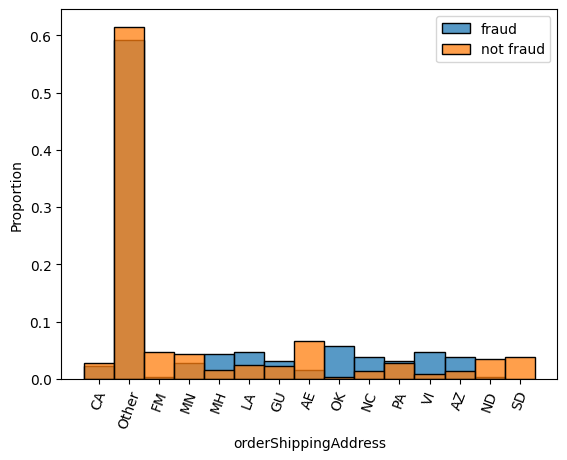

In [ ]:
fig, axs = plt.subplots()
sns.histplot(dataset.loc[(dataset['fraudulent']==1), 'orderShippingAddress'], label='fraud', ax=axs, stat='proportion')
sns.histplot(dataset.loc[(dataset['fraudulent']==0), 'orderShippingAddress'], label='not fraud', ax=axs, stat='proportion')
axs.set_xlabel('orderShippingAddress')
plt.xticks(rotation=70)
plt.legend()
plt.show()

Quick inspection of top shipping address states by class... some distinction between them, not too indicative

In [ ]:
for p in np.arange(0.1, 0.9, 0.1):
    print(f"p: {p}, n. uniques: {truncator(dataset['customer.customerBillingAddress'], percentile=p).nunique()}")

In [ ]:
dataset['customer.customerBillingAddress'] = truncator(dataset['customer.customerBillingAddress'], percentile=0.5)

In [ ]:
for p in np.arange(0.1, 0.9, 0.1):
    print(f"p: {p}, n. uniques: {truncator(dataset['customer.customerEmail'], percentile=p).nunique()}")

p: 0.1, n. uniques: 2
p: 0.2, n. uniques: 2
p: 0.30000000000000004, n. uniques: 3
p: 0.4, n. uniques: 3
p: 0.5, n. uniques: 4
p: 0.6, n. uniques: 8
p: 0.7000000000000001, n. uniques: 16
p: 0.8, n. uniques: 27


In [ ]:
dataset['customer.customerEmail'] = truncator(dataset['customer.customerEmail'], percentile=0.7)

In [ ]:
dataset.head()

,fraudulent,transactionAmount,transactionFailed,orderState,orderShippingAddress,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer,customer.customerEmail,customer.customerBillingAddress,orderCount,transactionCount,paymentMethodsCount,addressMismatch
0,False,18.0,False,pending,CA,True,card,JCB 16 digit,Citizens First Banks,yahoo.com,CA,2,2,1,True
1,False,26.0,False,fulfilled,CA,True,card,JCB 16 digit,Citizens First Banks,yahoo.com,CA,2,2,1,True
2,True,45.0,False,fulfilled,CA,False,bitcoin,American Express,Bastion Banks,yahoo.com,Other,3,3,7,False
3,True,23.0,False,fulfilled,Other,False,bitcoin,American Express,Bastion Banks,yahoo.com,Other,3,3,7,True
4,True,43.0,True,fulfilled,FM,True,bitcoin,VISA 16 digit,Solace Banks,yahoo.com,Other,3,3,7,False


## Modelling

I'll opt to use CatBoost for this task: the modelling process will be necessarily condensed, with no real model selection process due to time constraints.

From experience and intuition, GBDTs are likely to be highly suitable and potentially best-in-class for this task as it's formulated here. GBDTs are known for their performance on tabular data, can capture complex relationships and patterns, benefit from ensemble learning and are reasonably robust to noise and outliers, meaning we ought to be able to achieve reasonable performance without a huge amount of preamble or tweaking.

Additionally, we have a large number of categorical features, and CatBoost is specifically engineered to handle categorical variables well, with automatic feature encoding (hence why I haven't implemented my own cat feature encoding yet) and CatBoost is also known for delivering good performance out the box, which is again a perk for this project where there is not a lot of time available for extensive hparam tuning. I think it also comes with SHAP explanations wrapped, though if not then it is also highly conducive to SHAP/feature importance explanations, which is again key for this task.

In [ ]:
X = dataset.iloc[:, 1:]
y = dataset.iloc[:, 0].astype('int')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [ ]:
cat_indices = np.where(X.dtypes == np.object_)[0]

In [ ]:
train_pool = Pool(X_train, y_train, cat_indices)
test_pool = Pool(X_test, y_test, cat_indices)

In [ ]:
model = CatBoostClassifier(
    boosting_type='Ordered', # from the docs: 'usually provides better quality on small datasets'
    loss_function='Logloss',
    eval_metric='PRAUC:type=Classic', # PR AUC for binary classification
)

Note: choice of loss function and eval metric would be partially informed by context and domain knowledge of the problem at hand; for this task, logloss will probably suffice, but we could experiment with e.g. PRC-loss or focal loss if the imbalance was stronger and we wanted to focus more on positive examples or hard-to-classify cases. Similarly, PR AUC is used for optimisation due to its assumed suitability for imbalanced problems, though the imbalance is not overly pronounced in this case (hence why I also haven't experimented with class weights or other means of balancing classes). These are all things that obviously could/should be explored in a proper model selection process.

In [ ]:
%%time
model.fit(
    train_pool,
    eval_set=test_pool,
    logging_level='Verbose',
    plot=True,
    use_best_model=True,
    early_stopping_rounds=10,
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.026676
0:	learn: 0.9048451	test: 0.9006456	best: 0.9006456 (0)	total: 90.8ms	remaining: 1m 30s
1:	learn: 0.9113356	test: 0.9025860	best: 0.9025860 (1)	total: 123ms	remaining: 1m 1s
2:	learn: 0.9127456	test: 0.9036901	best: 0.9036901 (2)	total: 133ms	remaining: 44.3s
3:	learn: 0.9127456	test: 0.9036901	best: 0.9036901 (2)	total: 149ms	remaining: 37.1s
4:	learn: 0.9125135	test: 0.9015582	best: 0.9036901 (2)	total: 175ms	remaining: 34.9s
5:	learn: 0.9218169	test: 0.9237883	best: 0.9237883 (5)	total: 204ms	remaining: 33.7s
6:	learn: 0.9156340	test: 0.9214434	best: 0.9237883 (5)	total: 213ms	remaining: 30.2s
7:	learn: 0.9162014	test: 0.9225652	best: 0.9237883 (5)	total: 229ms	remaining: 28.4s
8:	learn: 0.9163095	test: 0.9252853	best: 0.9252853 (8)	total: 244ms	remaining: 26.9s
9:	learn: 0.9247355	test: 0.9262051	best: 0.9262051 (9)	total: 269ms	remaining: 26.7s
10:	learn: 0.9247355	test: 0.9262051	best: 0.9262051 (9)	total: 280ms	remaining: 25.2s
11:	learn: 0.9249864	

In [ ]:
model_outs = model.predict(X_test, 'Probability')

In [ ]:
cm = confusion_matrix(y_test, model.predict(X_test))

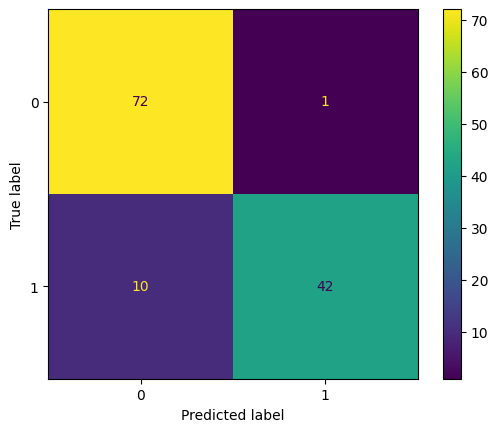

In [ ]:
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [ ]:
42/(42+10)

0.8076923076923077

Almost 100% precision with 81% recall... see if there is anything to be gained from changing decision threshold from default 0.5:

In [ ]:
predicted_probs = model.predict(X_test, 'Probability')

In [ ]:
pos_preds, neg_preds = predicted_probs[:,1], predicted_probs[:,0]

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, pos_preds, pos_label=1)

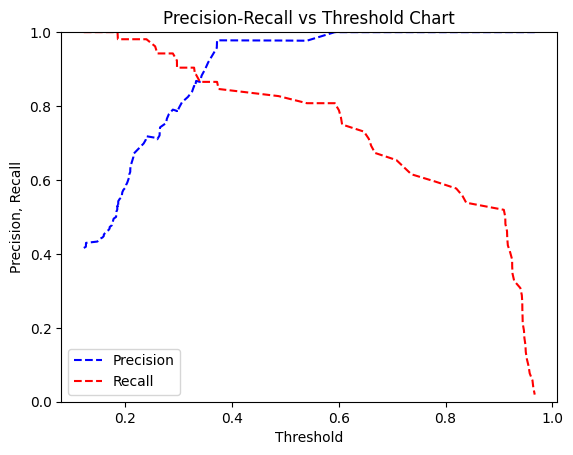

In [ ]:
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

Equal error rate point looks quite high, with ~90% precision and recall; given we have no information about the costs of a FN and FP, could opt to make this our decision threshold:

In [ ]:
df_precision_recall = pd.DataFrame({'Precision':precision[: -1],'Recall':recall[: -1]}, index=thresholds).round(4)
decision_threshold = df_precision_recall.query('Precision == Recall')

In [ ]:
decision_threshold

,Precision,Recall
0.340101,0.8654,0.8654


In [ ]:
from copy import copy

In [ ]:
y_hat = copy(pos_preds)

In [ ]:
y_hat = (y_hat>=0.340101)

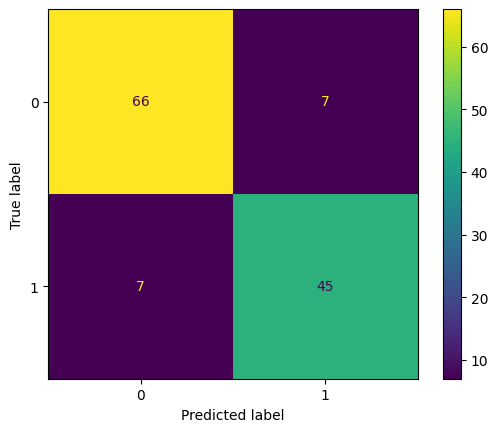

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat)).plot()
plt.show()

Next steps for the modelling process would be to gather all cleaning/preprocessing/modelling steps into a pipeline and carry out tuning, experimentation and optimisation on the model and to get a more general, cross-validated view of performance.

# Model Explanations/Feature Importance

Using SHAP for model explanations due to its widely known and appreciated status as a consistent and reliable method of achieving feature importance. Many other methods of determining feature importance have issues with consistency and have lots of caveats around their interpretation.

In [ ]:
shaps = model.get_feature_importance(Pool(X, y, cat_indices), type='ShapValues', )

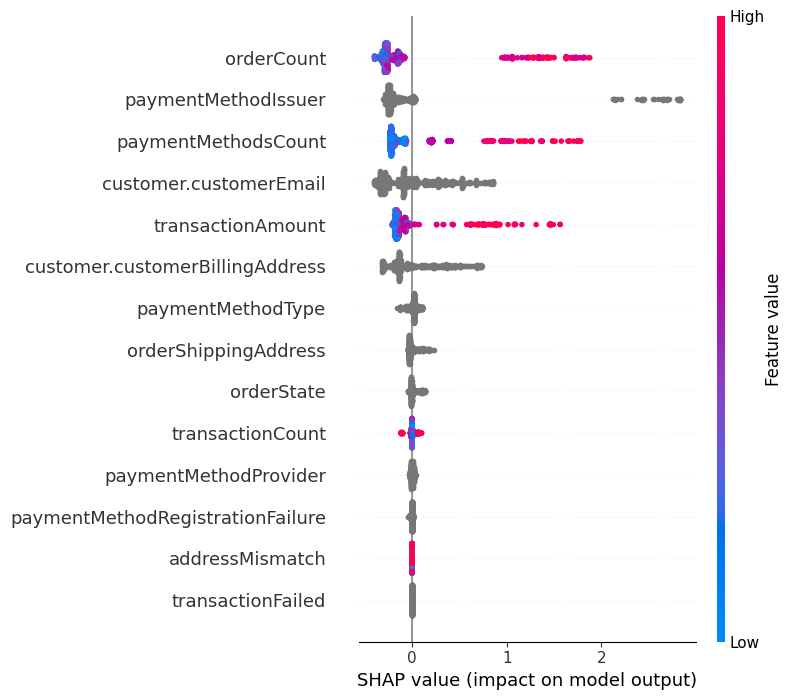

In [ ]:
shap.summary_plot(shaps[:,:-1], X)

A handful of features highly predictive for this application, including some that looked promising from EDA. Email domain is a slightly surprising top feature, as is billing address.

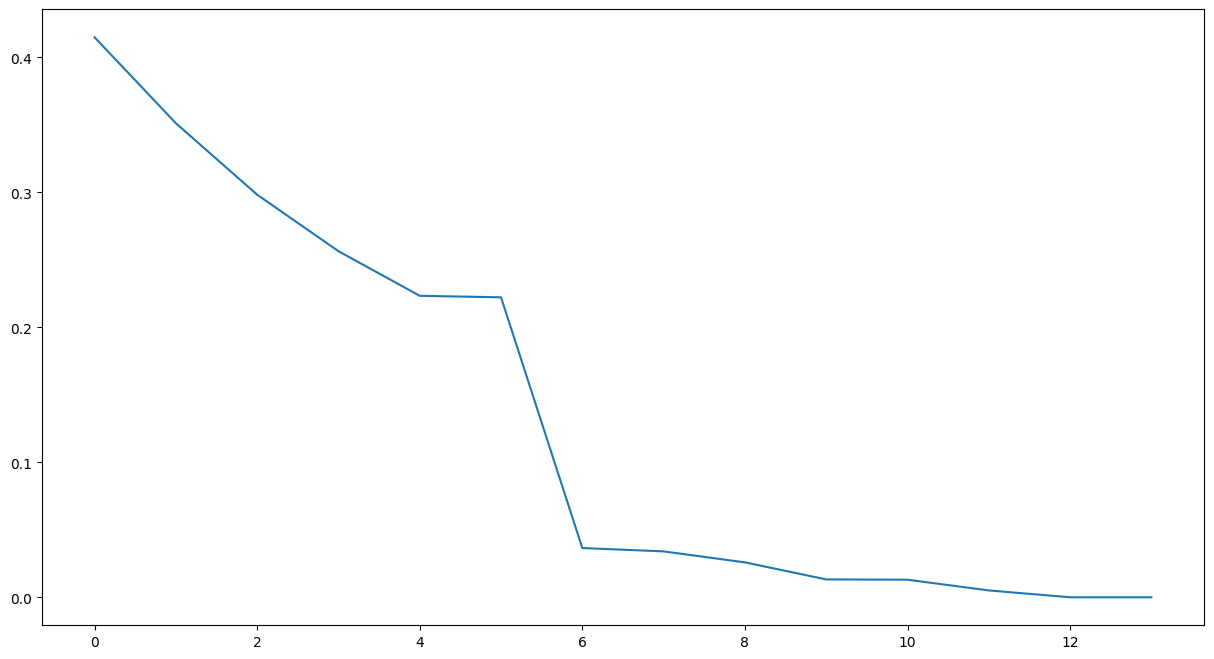

In [ ]:
# inspection of topmost important abs(shaps) shows a clear drop off at 6 features:
# could limit to top 6 for a more parsimonious model and expect little impact on performance

shap_df = pd.DataFrame(shaps[:,:-1], columns=X.columns)
abs(shap_df).mean(axis=0).sort_values(ascending=False).reset_index(drop=True).plot(kind='line', figsize=(15, 8))
plt.show()

In [ ]:
top_features_ordered = abs(shap_df).mean(axis=0).sort_values(ascending=False)
top_features_ordered

orderCount                          0.414881
paymentMethodIssuer                 0.351203
paymentMethodsCount                 0.298271
customer.customerEmail              0.256417
transactionAmount                   0.223346
customer.customerBillingAddress     0.222221
paymentMethodType                   0.036474
orderShippingAddress                0.033997
orderState                          0.025863
transactionCount                    0.013229
paymentMethodProvider               0.013009
paymentMethodRegistrationFailure    0.005076
transactionFailed                   0.000000
addressMismatch                     0.000000
dtype: float64

Possible next steps could be to investigate the feature values associated with having a high impact on model output, i.e. looking at feature level SHAP plots in order to understand patterns better, identify systemic problems or implement fraud detection rules and quick fixes, e.g.:

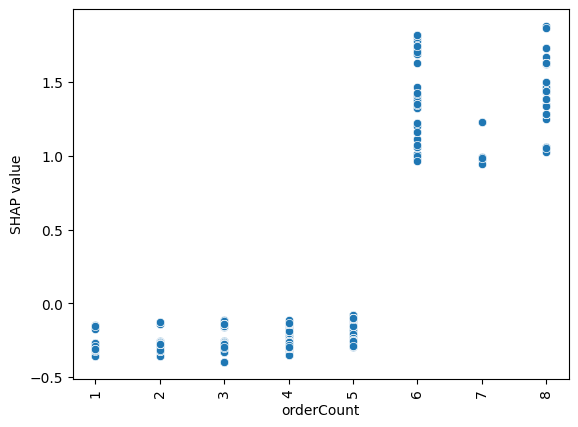

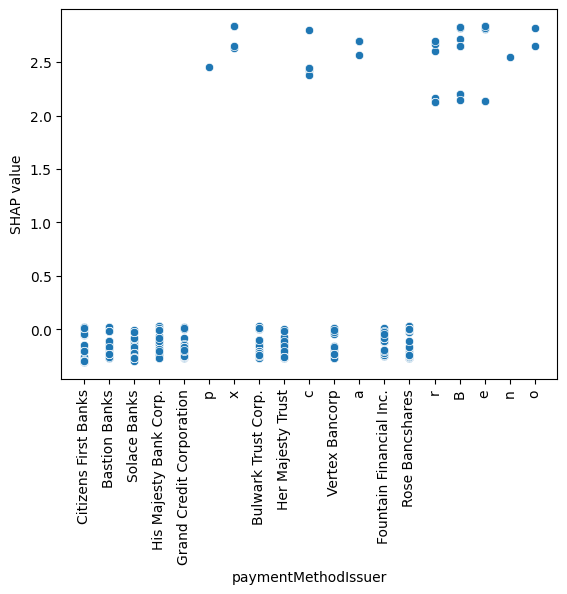

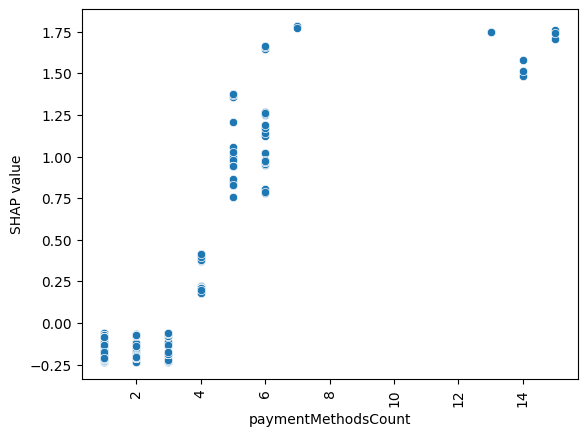

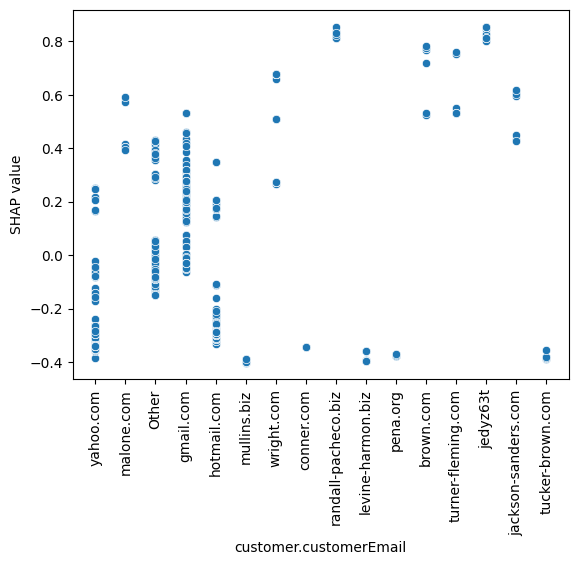

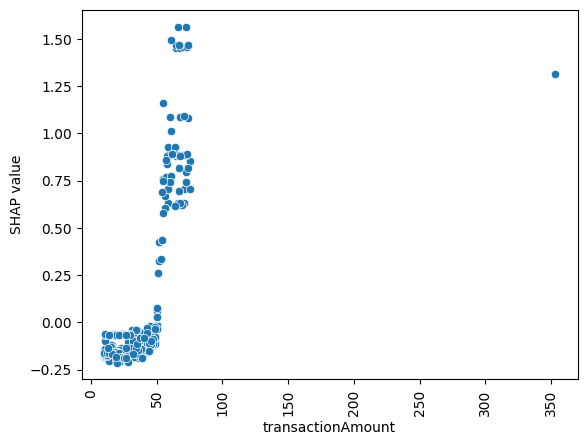

In [ ]:
for col in top_features_ordered.index[:5]:

  fig, axs = plt.subplots()

  sns.scatterplot(x=X[col], y=shap_df[col])
  axs.set_xlabel(col)
  axs.set_ylabel('SHAP value')
  plt.xticks(rotation=90)
  plt.show()

From this it's clear we can identify some quick flags or obvious insights, such as customers with more than 5 orders within whatever timeframe these profiles represent are high fraud risk, and might ought to be flagged or investigated.

Similarly, there needs some investigation into paymentMethodIssuer to find out where those single letter values are generated as they correspond frequently to fraud, more than 5 different paymentMethods to a customer might be suspicious, etc., etc.

These can also give more insight into fraud patterns or additional areas of feature selection/engineering.

Final thoughts/areas for seeking clarification:

This approach is biased towards instances with more transactions; the model 'sees' more of the same kind of instance if it has lots of transactions vs. instances with just one or two, and if the model can identify one transaction from a fraudulent customer as fraud then it ought to correctly label the other transactions by that customer due to the large amount of redundancy across features for transactions from the same customer.

This isn't necessarily a problem: if we're building a model to be invoked at the point of transaction and the patterns are in the data and represent true transaction fraud, then they ought to be learnt from. Wonder if it could be a problem for evaluation though? As could inflate/skew metrics or hide systemic failures or poor performance on certain less-frequent patterns... Could look at hard to classify patterns and try to learn more, or apply balancing techniques for instances with few transactions if we found it helped the model learn those instances?